In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import seaborn as sns
import scipy.stats
import anndata
import os
import scipy as scipy
import scipy as sp
import pickle as pkl
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import asarray as ar
from collections import Counter
import networkx as nx
import igraph
import glob

import bbknn

os.getcwd()

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='Blues')
sc.logging.print_version_and_date()
sc.logging.print_header()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vi8no1yi because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Running Scanpy 1.6.0, on 2022-03-07 12:23.
scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.8 louvain==0.7.0


In [2]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def subtraction(lst1, lst2): 
    lst3 = [value for value in lst1 if not value in lst2] 
    return lst3

#### reading input data

In [3]:
adata1 = sc.read('/mnt/Science_revision/write/TICA_5prime_donors.h5ad')

In [4]:
adata2 = sc.read('/mnt/Science_revision/write/TICA_hashtagged5prime_donors_TEST.h5ad')

In [5]:
adata1

AnnData object with n_obs × n_vars = 94448 × 36601
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'sample ID_colors'

In [6]:
adata2

AnnData object with n_obs × n_vars = 98584 × 36601
    obs: 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'fraction_mito', 'n_counts', 'n_genes', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0257', 'fraction_HTO_C0256', 'batch', 'hash+lib', 'sample_ID', 'organ_code', 'donor_id', 'Stimulation'
    var: 'gene_ids', 'feature_types'

In [7]:
adata2.obs['Stimulation'].unique()

['Nonstim']
Categories (1, object): ['Nonstim']

In [8]:
adata1.X.min()

0.0

In [9]:
adata2.X.min()

0.0

In [10]:
adata1.obs['organ_code'] = adata1.obs['organ code']

In [11]:
adata1.obs['donor_id'] = adata1.obs['patient no']

In [12]:
del adata1.raw

In [13]:
del adata2.raw

In [14]:
holder = [adata1, adata2]

In [15]:
adata = holder[0].concatenate(holder[1:], join='outer', index_unique=None)

In [16]:
adata

AnnData object with n_obs × n_vars = 193032 × 36601
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'organ_code', 'donor_id', 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0257', 'fraction_HTO_C0256', 'hash+lib', 'sample_ID', 'Stimulation'
    var: 'gene_ids', 'feature_types'

In [17]:
nydata = sc.read('/mnt/Science_revision/write/TICA_hashtagged3prime_donors.h5ad')

In [18]:
adata.X.min()

0.0

In [19]:
holder = [adata, nydata]

In [20]:
adata

AnnData object with n_obs × n_vars = 193032 × 36601
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'organ_code', 'donor_id', 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0257', 'fraction_HTO_C0256', 'hash+lib', 'sample_ID', 'Stimulation'
    var: 'gene_ids', 'feature_types'

In [21]:
nydata

AnnData object with n_obs × n_vars = 175777 × 36601
    obs: 'combined_ID', 'C251', 'C252', 'C253', 'C254', 'C255', 'C256', 'C257', 'C258', 'total_hto_counts', 'fraction_HTOC251', 'fraction_HTOC252', 'fraction_HTOC253', 'fraction_HTOC254', 'fraction_HTOC255', 'fraction_HTOC256', 'fraction_HTOC257', 'fraction_HTOC258', 'fraction_mito', 'n_counts', 'n_genes', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'batch', 'hash+lib', 'sample_ID', 'organ_code', 'donor_id'
    var: 'gene_ids', 'feature_types'

In [22]:
adata = holder[0].concatenate(holder[1:], join='outer', index_unique=None)

/home/ubuntu/.local/lib/python3.6/site-packages/anndata/_core/merge.py:918: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


In [23]:
adata

AnnData object with n_obs × n_vars = 368809 × 36601
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'organ_code', 'donor_id', 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0257', 'fraction_HTO_C0256', 'hash+lib', 'sample_ID', 'Stimulation', 'C251', 'C252', 'C253', 'C254', 'C255', 'C256', 'C257', 'C258', 'fraction_HTOC251', 'fraction_HTOC252', 'fraction_HTOC253', 'fraction_HTOC254', 'fraction_HTOC255', 'fraction_HTOC256', 'fraction_HTOC257', 'fraction_HTOC258'
    var: 'gene_ids', 'feature_types'

In [24]:
adata.obs = adata.obs.replace(to_replace='BLO',value='BLD')

In [25]:
adata.obs['organ_code'].unique()

array(['ILE', 'LNG', 'TLN', 'MLN', 'BMA', 'SKM', 'LIV', 'SPL', 'OME',
       'CAE', 'THY', 'DUO', 'BLD', 'TCL', 'SCL', 'JEJLP', 'JEJEPI', 'LLN'],
      dtype=object)

In [26]:
adata.X.min()

0.0

In [27]:
adata.raw = adata

In [28]:
## add the chemistry

chem = {'A29':'5v1',
 'A31':'5v1',
 'A36':'5v1',
 'A35':'5v1',
 'A37':'5v1',
 'A52':'5v1',
 '582C':'5v2',
 '621B':'5v2',
 '637C':'5v2',
 '640C':'5v2',
 'D503':'3',
 'D496':'3'
}

In [29]:
adata.obs['chem'] = adata.obs['donor_id'].map(chem)

In [30]:
adata.obs['chem'].unique()

array(['5v1', '5v2', '3'], dtype=object)

In [31]:
adata.write('/mnt/Science_revision/write/TICA_merged.h5ad')

... storing 'sample' as categorical
... storing 'Source ID' as categorical
... storing 'sex' as categorical
... storing 'patient no' as categorical
... storing 'organ code' as categorical
... storing 'sample ID' as categorical
... storing 'organ_code' as categorical
... storing 'donor_id' as categorical
... storing 'combined_ID' as categorical
... storing 'Classification' as categorical
... storing 'hash+lib' as categorical
... storing 'sample_ID' as categorical
... storing 'Stimulation' as categorical
... storing 'chem' as categorical


## preprocessing

In [32]:
adata = sc.read('/mnt/Science_revision/write/TICA_merged.h5ad')

In [33]:
adata.X

<368809x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 714404854 stored elements in Compressed Sparse Row format>

In [34]:
adata.X.shape

(368809, 36601)

#### removing doublets based on scrublet output

In [35]:
samples = ['Pan_T7935490',
 'Pan_T7935492',
 'Pan_T7935493',
 'Pan_T7935494',
 'Pan_T7935495',
 'Pan_T7935496',
 'Pan_T7935497',
 'Pan_T7935491',
 'Pan_T7917815',
 'Pan_T7917816',
 'Pan_T7917817',
 'Pan_T7917818',
 'Pan_T7917819',
 'Pan_T7917820',
 'Pan_T7917821',
 'Pan_T7917822',
 'Pan_T7917823',
 'Pan_T7917824',
 'Pan_T7917826',
 'Pan_T7917827',
 'Pan_T7980358',
 'Pan_T7980359',
 'Pan_T7980360',
 'Pan_T7980361',
 'Pan_T7980364',
 'Pan_T7980365',
 'Pan_T7980366',
 'Pan_T7980367',
 'Pan_T7980368',
 'Pan_T7980369',
 'Pan_T7980370',
 'Pan_T7991584',
 'Pan_T7991585',
 'Pan_T7991586',
 'Pan_T7991587',
 'Pan_T7991588',
 'Pan_T7991589',
 'Pan_T7991590',
 'Pan_T7991591',
 'Pan_T7991592',
 'Pan_T7991593',
 'Pan_T7991594',
 'Pan_T7991595',
 'Pan_T8010318',
 'Pan_T8010319',
 'Pan_T8010320',
 'Pan_T8010321',
 'Pan_T8010323',
 'Pan_T8010325',
 'Pan_T8010326',
 'Pan_T8010327',
 'Pan_T8010330',
 'Pan_T8010331',
 'Pan_T7935487',
 'Pan_T7935488',
 'Pan_T7935489',
 'Pan_T8986827',
 'Pan_T8986828',
 'Pan_T8986829',
 'Pan_T8986830',
 'Pan_T8986831',
 'CZINY-0049',
 'CZINY-0097',
 'CZINY-0050',
 'CZINY-0098',
 'CZINY-0051',
 'CZINY-0099',
 'CZINY-0052',
 'CZINY-0100',
 'CZINY-0053',
 'CZINY-0101',
 'CZINY-0054',
 'CZINY-0102',
 'CZINY-0055',
 'CZINY-0103',
 'CZINY-0056',
 'CZINY-0104',
 'CZINY-0057',
 'CZINY-0105',
 'CZINY-0058',
 'CZINY-0106',
 'CZINY-0059',
 'CZINY-0107',
 'CZINY-0060',
 'CZINY-0108',
 'CZINY-0061',
 'CZINY-0109',
 'CZINY-0062',
 'CZINY-0110',
 'CZINY-0063',
 'CZINY-0111',
 'CZINY-0064',
 'CZINY-0112',
'CZI-IA9924320+CZI-IA9924368',
 'CZI-IA9924321+CZI-IA9924369',
 'CZI-IA10244332+CZI-IA10244434',
 'CZI-IA10244331+CZI-IA10244433',
 'CZI-IA10466281+CZI-IA10466377',
 'CZI-IA10466282+CZI-IA10466378',
 'CZI-IA10466283+CZI-IA10466379',
 'CZI-IA10466284+CZI-IA10466380',
 'CZI-IA10466285+CZI-IA10466381',
 'CZI-IA10466286+CZI-IA10466382',
 'CZI-IA10471909+CZI-IA10472005',
 'CZI-IA10471910+CZI-IA10472006',
 'CZI-IA10471911+CZI-IA10472007',
 'CZI-IA10471912+CZI-IA10472008',
 'CZI-IA10471913+CZI-IA10472009']

In [36]:
holder = []

for sample in samples:
    holder.append(pd.read_csv('/mnt/Science_revision/pip-scrublet/'+sample+'.csv'))
    holder[-1].index = [sample+'_'+i.split('-')[0] for i in holder[-1]['index']]


In [37]:
scrub = pd.concat(
    holder,
    axis=0,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

In [38]:
scrub.head(1)

,index,scrublet_leiden,scrublet_score,cluster_scrublet_score,doublet_pval,doublet_bh_pval
Pan_T7935490_AAACCTGAGACACGAC,AAACCTGAGACACGAC-1,"3,12",0.009804,0.01456,0.916676,0.931308


In [39]:
scrub.tail(1)

,index,scrublet_leiden,scrublet_score,cluster_scrublet_score,doublet_pval,doublet_bh_pval
CZI-IA10471913+CZI-IA10472009_TTTGTCATCGTAGATC,TTTGTCATCGTAGATC-1,"0,63",0.099117,0.096525,0.372859,0.900513


In [40]:
for col in scrub.columns:
    adata.obs[col] = scrub[col]

In [41]:
adata.obs['is_doublet'] = adata.obs['doublet_bh_pval'] < 0.1

In [42]:
adata.obs['is_doublet'].value_counts()

False    357211
True      11598
Name: is_doublet, dtype: int64

In [43]:
adata

AnnData object with n_obs × n_vars = 368809 × 36601
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'organ_code', 'donor_id', 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0257', 'fraction_HTO_C0256', 'hash+lib', 'sample_ID', 'Stimulation', 'C251', 'C252', 'C253', 'C254', 'C255', 'C256', 'C257', 'C258', 'fraction_HTOC251', 'fraction_HTOC252', 'fraction_HTOC253', 'fraction_HTOC254', 'fraction_HTOC255', 'fraction_HTOC256', 'fraction_HTOC257', 'fraction_HTOC258', 'chem', 'index', 'scrublet_leiden', 'scrublet_score', 'cluster_scrubl

In [44]:
adata.obs['is_doublet'].value_counts()

False    357211
True      11598
Name: is_doublet, dtype: int64

In [46]:
adata = adata[~adata.obs['is_doublet']]

In [47]:
adata

View of AnnData object with n_obs × n_vars = 357211 × 36601
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'organ_code', 'donor_id', 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0257', 'fraction_HTO_C0256', 'hash+lib', 'sample_ID', 'Stimulation', 'C251', 'C252', 'C253', 'C254', 'C255', 'C256', 'C257', 'C258', 'fraction_HTOC251', 'fraction_HTOC252', 'fraction_HTOC253', 'fraction_HTOC254', 'fraction_HTOC255', 'fraction_HTOC256', 'fraction_HTOC257', 'fraction_HTOC258', 'chem', 'index', 'scrublet_leiden', 'scrublet_score', 'cluste

In [48]:
### Total of 357,211 high quality singlets

In [49]:
adata.write('/mnt/Science_revision/write/TICA_merged_singlets.h5ad')

/home/ubuntu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'index' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'scrublet_leiden' as categorical


#### Immune cells were selected based on CellTypist results and manual curation

In [50]:
adata = sc.read('/mnt/Science_revision/write/TICA_merged_singlets_immune.h5ad')

In [51]:
adata

AnnData object with n_obs × n_vars = 329762 × 1292
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'organ_code', 'donor_id', 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0256', 'fraction_HTO_C0257', 'hash+lib', 'sample_ID', 'leiden', 'Stimulation', 'C251', 'C252', 'C253', 'C254', 'C255', 'C256', 'C257', 'C258', 'fraction_HTOC251', 'fraction_HTOC252', 'fraction_HTOC253', 'fraction_HTOC254', 'fraction_HTOC255', 'fraction_HTOC256', 'fraction_HTOC257', 'fraction_HTOC258', 'chem', 'index', 'scrublet_leiden', 'scrublet_score', 'clust

In [52]:
### Total of 329,762 high quality singlets

In [53]:
adata.obs['Category'] = pd.read_csv("/mnt/Science_revision/global_object_category_1112.csv", header=None)[0].values

... storing 'Category' as categorical


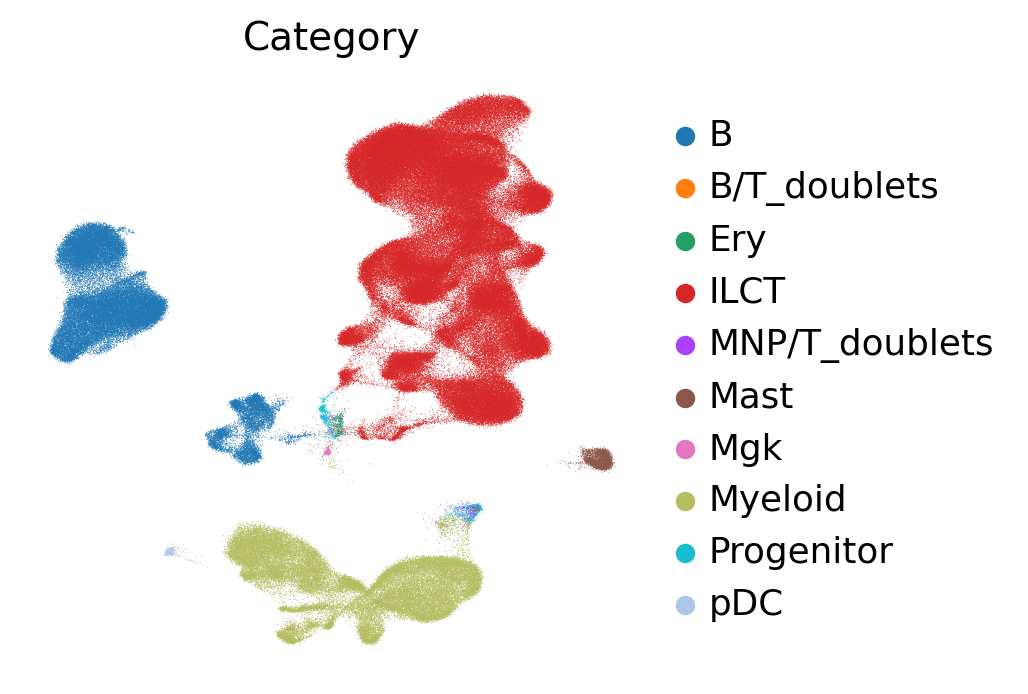

In [54]:
sc.pl.umap(adata, color='Category', frameon=False)

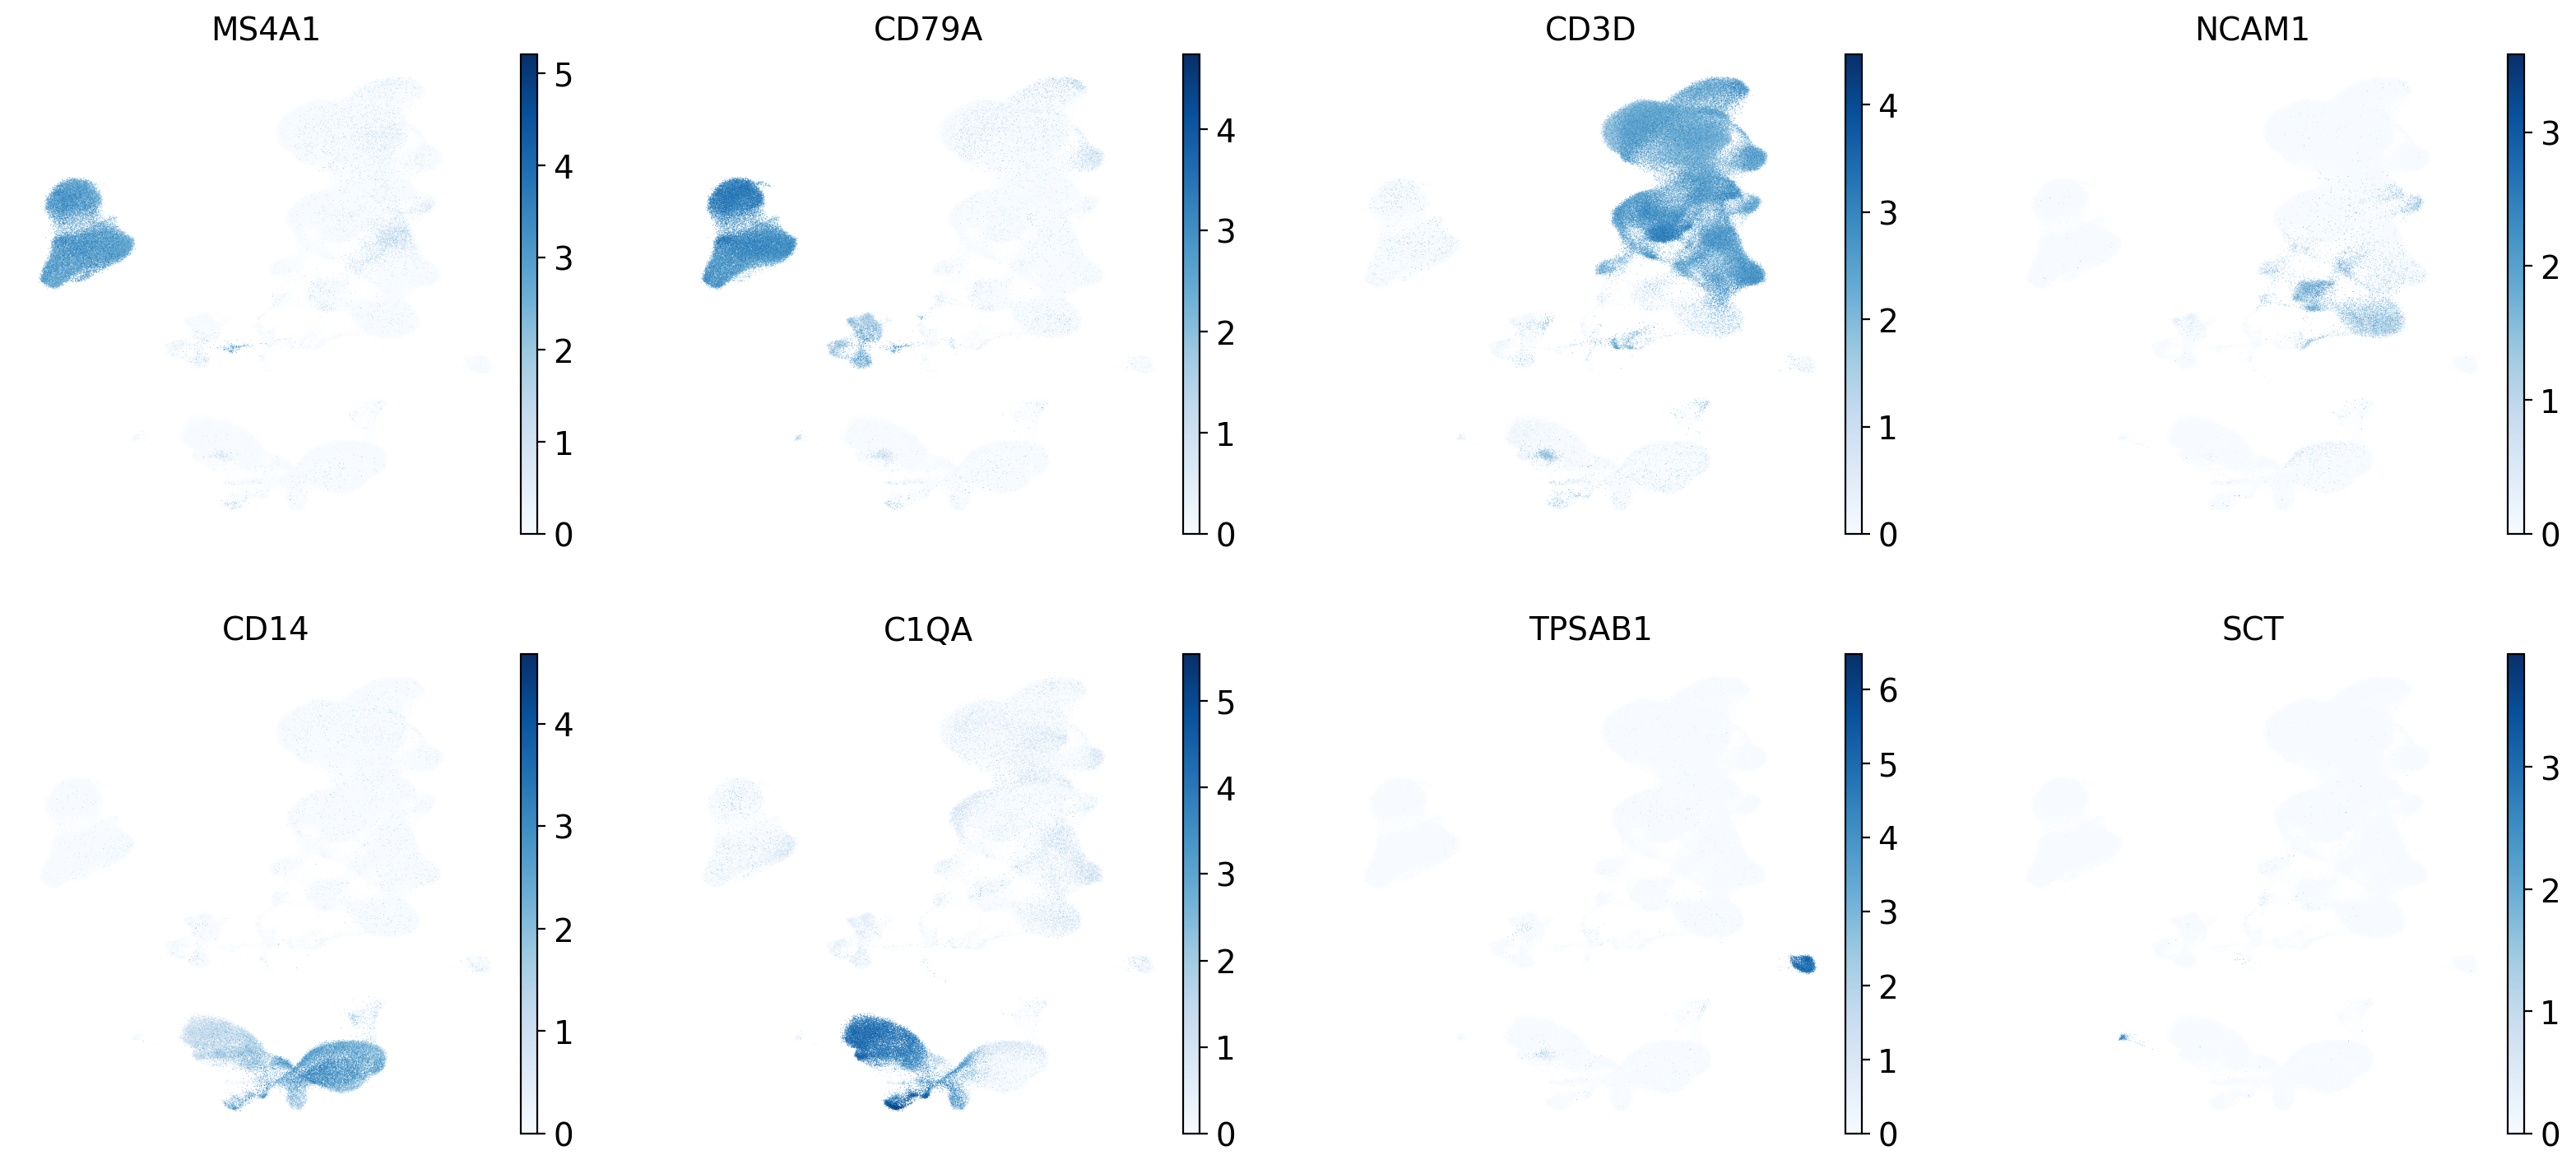

In [55]:
sc.pl.umap(adata, color=['MS4A1','CD79A','CD3D','NCAM1','CD14','C1QA','TPSAB1','SCT'], frameon=False)

In [ ]:
adata.write('/mnt/Science_revision/write/TICA_merged_singlets_immune.h5ad')